In [1]:
import sys
sys.path.append('/home/s/seanmacb/Camera/pkgs')
import run_six_utils as rsu
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('matplotlib') 
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def openProcess(boo,r):

    base_dir = '/home/s/seanmacb/Camera/Run6Comparisons/Data/Roll-off/Median_fixed/{}/'.format(r)
        
    if boo:
        E2V_Normed_x,ITL_Normed_x,E2V_Normed_x_std,ITL_Normed_x_std = rsu.getAllCals(img,r,axis='x',verbose=True,median=True) # Binned along x for all detectors
        E2V_Normed_y,ITL_Normed_y,E2V_Normed_y_std,ITL_Normed_y_std = rsu.getAllCals(img,r,axis='y',verbose=True,median=True) # binned along y for non-edge detectors
        E2V_Normed_y_edge,ITL_Normed_y_edge,E2V_Normed_y_edge_std,ITL_Normed_y_edge_std = rsu.getAllCals(img,r,axis='y',edge=True,verbose=True,median=True) # This should only give the edge detectors in ITL - check by subtracting E2V in y from the E2V in the above line
        
        np.savetxt(base_dir+"E2Vdata_x.txt",E2V_Normed_x)
        np.savetxt(base_dir+"ITLdata_x.txt",ITL_Normed_x)
        np.savetxt(base_dir+"E2Vdata_y.txt",E2V_Normed_y)
        np.savetxt(base_dir+"ITLdata_y.txt",ITL_Normed_y)
        np.savetxt(base_dir+"ITLdata_y_edge.txt",ITL_Normed_y_edge)
        # Add the std
        np.savetxt(base_dir+"ITLdata_y_std_edge.txt",ITL_Normed_y_edge_std)
        np.savetxt(base_dir+"E2Vdata_y_std.txt",E2V_Normed_y_std)
        np.savetxt(base_dir+"ITLdata_y_std.txt",ITL_Normed_y_std)
        np.savetxt(base_dir+"ITLdata_y_std.txt",ITL_Normed_x_std)
        np.savetxt(base_dir+"E2Vdata_x_std.txt",E2V_Normed_x_std)
        return
    else:
        E2V_Normed_x = np.loadtxt(base_dir+"E2Vdata_x.txt")
        ITL_Normed_x = np.loadtxt(base_dir+"ITLdata_x.txt")
        E2V_Normed_y = np.loadtxt(base_dir+"E2Vdata_y.txt")
        ITL_Normed_y = np.loadtxt(base_dir+"ITLdata_y.txt")
        ITL_Normed_y_edge = np.loadtxt(base_dir+"ITLdata_y_edge.txt")
        # add std
        ITL_Normed_y_edge_std = np.loadtxt(base_dir+"ITLdata_y_std_edge.txt")
        E2V_Normed_y_std = np.loadtxt(base_dir+"E2Vdata_y_std.txt")
        ITL_Normed_y_std = np.loadtxt(base_dir+"ITLdata_y_std.txt")
        ITL_Normed_x_std = np.loadtxt(base_dir+"ITLdata_y_std.txt")
        E2V_Normed_x_std = np.loadtxt(base_dir+"E2Vdata_x_std.txt")
        return E2V_Normed_x,ITL_Normed_x,E2V_Normed_y,ITL_Normed_y,ITL_Normed_y_edge,ITL_Normed_y_edge_std,E2V_Normed_y_std,ITL_Normed_y_std,ITL_Normed_x_std,E2V_Normed_x_std


save=False # if True, then it will re-run all the analysis. If false, then it will just open the arrays

# E2V_Normed_x,ITL_Normed_x,E2V_Normed_y,ITL_Normed_y,ITL_Normed_y_edge,ITL_Normed_y_edge_std,E2V_Normed_y_std,ITL_Normed_y_std,ITL_Normed_x_std,E2V_Normed_x_std = openProcess(save,run[3])

In [3]:
img= 'flat'
run = ['13391_w_2023_24','13401_w_2023_24','13505_w_2023_41', '13550_w_2023_41'] # 13505 and 13550 are gain corrected, 
axes = ["x","y"]
norm=True
median=True

for run_num in run:
    print("Run id: {}".format(run_num))
    serial_Arr,midline_Arr,parallel_Arr = np.array([]),np.array([]),np.array([])
    for axis in axes:
        print("For axis",axis)
        for detector in np.arange(0,205):
            avg_arr,std_arr,axis,manu_type = rsu.statisticsHandler(img,run_num,detector,axis,norm,median)
            if axis=="x": # measuring along serial
                serial_Arr = np.append(serial_Arr, np.mean([rsu.findEdgeCutoffs(avg_arr,side='left'),
                                                            rsu.findEdgeCutoffs(avg_arr,side='right')]))
            else: # measuring along parallel
                parallel_Arr = np.append(parallel_Arr, np.mean([rsu.findEdgeCutoffs(avg_arr,side='left'),
                                                                rsu.findEdgeCutoffs(avg_arr,side='right')]))
                midline_Arr = np.append(midline_Arr, rsu.findMinMidline(avg_arr)) # be more precise with the midline calculation - currently doing four, need to do 5
            if detector%25==0:
                print("Finished detector",detector)
    
    # Make the plot here

    ITL_bounds = [  0,  35,  72, 80, 162, 204]
    E2V_bounds = [ 36,  71, 81, 161]
    
    fig,ax = plt.subplots(figsize=[10,5])
    
    fig.suptitle("Run {} Detector Deviation Thresholds, if Set by LCA-19636-A".format(run_num))
    
    lab1, = ax.plot(np.arange(0,205),serial_Arr,label="Serial Edge Estimate",color='blue',marker="D",ls='None',markersize=4)
    lab2, = ax.plot(np.arange(0,205),parallel_Arr,label="Parallel Edge Estimate",color='black',marker="X",ls='None',markersize=4)
    lab3, = ax.plot(np.arange(0,205)[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"],
            midline_Arr[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"],label="Mid-line Bloom",
            color='green',marker=".",markersize=10,ls="None")
    
    # ax.axhline(1,label="ITL serial edge from global",ls="-.",color='indigo')
    ax.fill_between(np.arange(0,205),0,1,label=None,where=(rsu.get_serial_from_number(np.arange(0,205)) == "ITL"),**{"color":"blue","alpha":0.5},hatch="///")
    lab5 = ax.fill_between(np.arange(0,205),6,7,label="Serial edge from global",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"blue","alpha":0.5},hatch="///")
    # ax.axhline(6,label="E2V serial edge from global",ls="--",color='violet') # This is a range of 6-7
    
    values = [3.33,4]
    labels = [None,"Parallel edge from global"]
    kwargs = [{"color":'black',"ls":"-."},{'color':"black","ls":"-."}]
    # It would be nice to mask these hlines
    iter = 0
    for bounds in (ITL_bounds,E2V_bounds):
        newlabel=labels[iter]
        startIter = 0
        for left,right in zip(bounds[::2],bounds[1::2]):
            lab6tmp = ax.hlines(values[iter],left,right,**kwargs[iter],label=newlabel)
            # print(left,right)
            if startIter==0:
                lab6 = lab6tmp
                newlabel = None
                startIter +=1
        iter+=1
    
    # ax.axhline(3.33,label="ITL parallel edge from global",ls="-.",color='indigo')
    # ax.axhline(4,label="E2V parallel edge from global",ls="--",color='goldenrod')
    
    # Plot the range at which the E2V midline bloom plot was to be centered
    lab4 = ax.fill_between(np.arange(0,205),2,3,label="Midline threshold from global",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"green","alpha":0.3,"hatch":"///"})
    
    # this is to show which are E2V, and which are ITL
    lab7 = ax.fill_between(np.arange(0,205),-1,200,label="ITL",where=(rsu.get_serial_from_number(np.arange(0,205)) == "ITL"),**{"color":"white","alpha":0.5,"edgecolor":"black"})
    lab8 = ax.fill_between(np.arange(0,205),-1,200,label="E2V",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"black","alpha":0.15})
    
    ax.set_xlabel("Detector #")
    ax.set_ylabel("Threshold [%]")
    ax.set_xlim(-1,206)
    ax.set_yticks(np.arange(0,12,step=1))
    ax.set_ylim(-1,11.5)
    ax.set_xticks(np.arange(0,205,step=8))
    ax.grid()
    
    ax.legend(ncols=2,handles = [lab1,lab2,lab3,lab7,lab5,lab6,lab4,lab8])
    
    fig.tight_layout()
    
    fig.show()
    
    fig.savefig("/home/s/seanmacb/Camera/Run6Comparisons/Figures/LCADeviationThresholds/{}.jpg".format(run_num),dpi=200)

Run id: 13391_w_2023_24
For axis x
Finished detector 0


KeyboardInterrupt: 

# Redoing now with new buffer size, this time it is 5 for the edges

Run id: 13391_w_2023_24
For axis x
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 100
Finished detector 125
Finished detector 150
Finished detector 175
Finished detector 200
For axis y
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 100
Finished detector 125
Finished detector 150
Finished detector 175
Finished detector 200
Run id: 13401_w_2023_24
For axis x
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 100
Finished detector 125
Finished detector 150
Finished detector 175
Finished detector 200
For axis y
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 100
Finished detector 125
Finished detector 150
Finished detector 175
Finished detector 200
Run id: 13505_w_2023_41
For axis x
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 

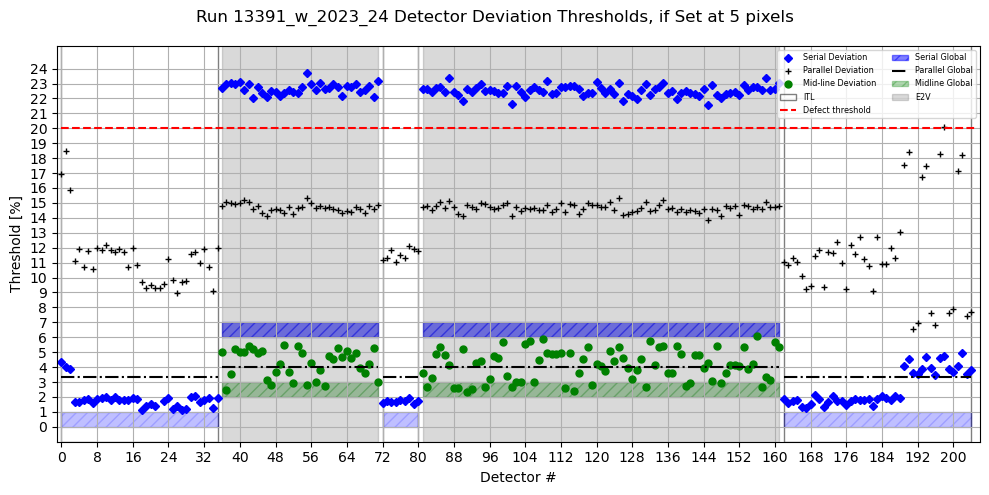

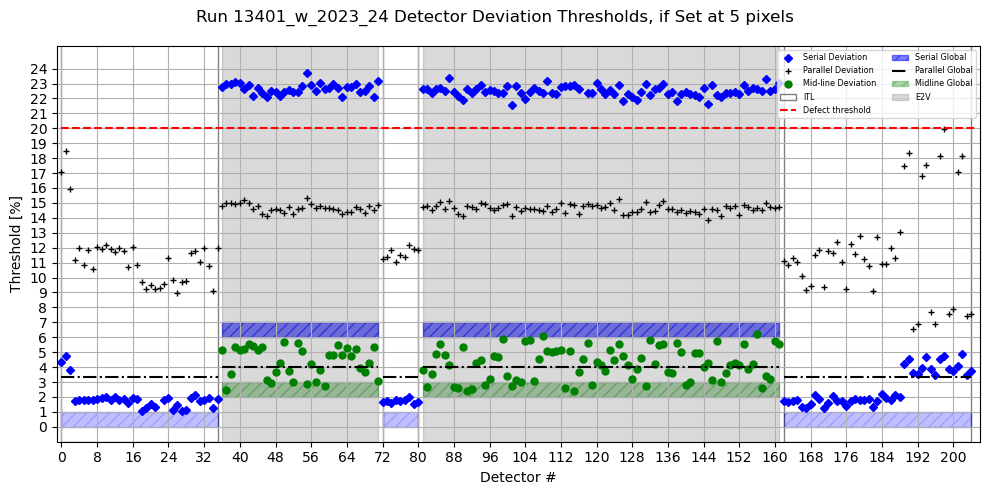

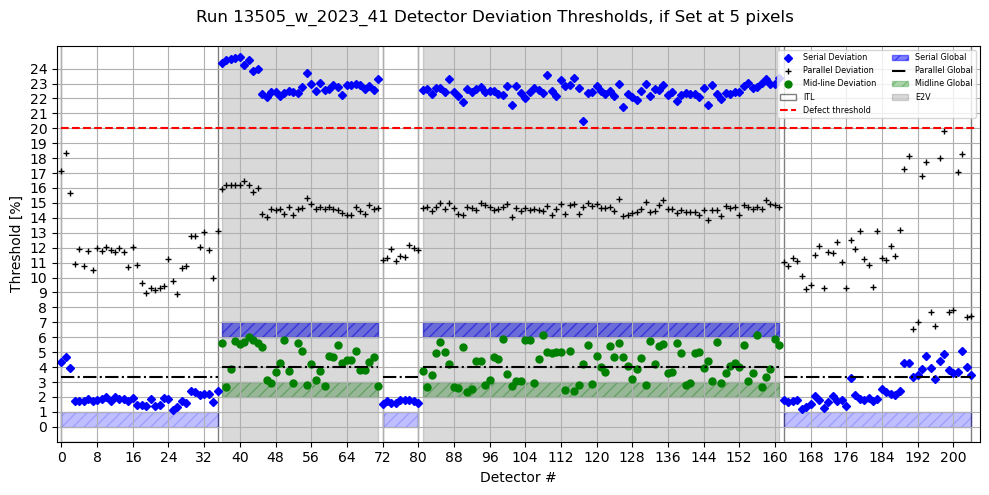

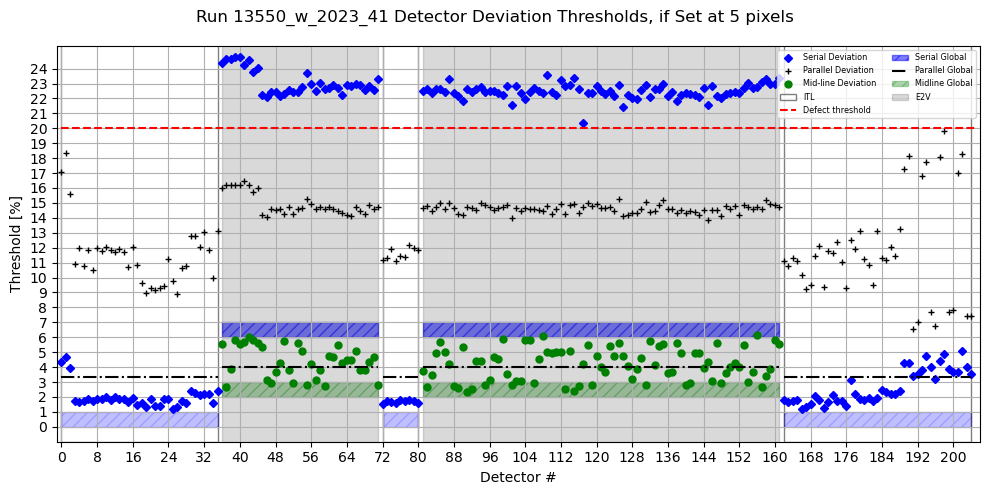

In [28]:
img= 'flat'
run = ['13391_w_2023_24','13401_w_2023_24','13505_w_2023_41', '13550_w_2023_41'] # 13505 and 13550 are gain corrected, 
axes = ["x","y"]
norm=True
median=True

for run_num in run:
    print("Run id: {}".format(run_num))
    serial_Arr,midline_Arr,parallel_Arr = np.array([]),np.array([]),np.array([])
    for axis in axes:
        print("For axis",axis)
        for detector in np.arange(0,205):
            avg_arr,std_arr,axis,manu_type = rsu.statisticsHandler(img,run_num,detector,axis,norm,median)
            if axis=="x": # measuring along serial
                serial_Arr = np.append(serial_Arr, np.mean([rsu.findEdgeCutoffs(avg_arr,side='left',sugOverride=5),
                                                            rsu.findEdgeCutoffs(avg_arr,side='right',sugOverride=5)]))
            else: # measuring along parallel
                parallel_Arr = np.append(parallel_Arr, np.mean([rsu.findEdgeCutoffs(avg_arr,side='left',sugOverride=5),
                                                                rsu.findEdgeCutoffs(avg_arr,side='right',sugOverride=5)]))
                midline_Arr = np.append(midline_Arr, rsu.findMinMidline(avg_arr)) # be more precise with the midline calculation - currently doing four, need to do 5
            if detector%25==0:
                print("Finished detector",detector)
    
    # Make the plot here

    ITL_bounds = [  0,  35,  72, 80, 162, 204]
    E2V_bounds = [ 36,  71, 81, 161]
    
    fig,ax = plt.subplots(figsize=[10,5])
    
    fig.suptitle(r"Run {} Detector Deviation Thresholds, if Set at 5 pixels".format(run_num))
    
    lab1, = ax.plot(np.arange(0,205),serial_Arr,label="Serial Deviation",color='blue',marker="D",ls='None',markersize=4)
    lab2, = ax.plot(np.arange(0,205),parallel_Arr,label="Parallel Deviation",color='black',marker="+",ls='None',markersize=4)
    lab3, = ax.plot(np.arange(0,205)[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"],
            midline_Arr[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"],label="Mid-line Deviation",
            color='green',marker=".",markersize=10,ls="None")
    
    # ax.axhline(1,label="ITL serial edge from global",ls="-.",color='indigo')
    ax.fill_between(np.arange(0,205),0,1,label=None,where=(rsu.get_serial_from_number(np.arange(0,205)) == "ITL"),**{"color":"blue","alpha":0.5},hatch="///")
    lab5 = ax.fill_between(np.arange(0,205),6,7,label="Serial Global",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"blue","alpha":0.5},hatch="///")
    # ax.axhline(6,label="E2V serial edge from global",ls="--",color='violet') # This is a range of 6-7
    
    values = [3.33,4]
    labels = [None,"Parallel Global"]
    kwargs = [{"color":'black',"ls":"-."},{'color':"black","ls":"-."}]
    # It would be nice to mask these hlines
    iter = 0
    for bounds in (ITL_bounds,E2V_bounds):
        newlabel=labels[iter]
        startIter = 0
        for left,right in zip(bounds[::2],bounds[1::2]):
            lab6tmp = ax.hlines(values[iter],left,right,**kwargs[iter],label=newlabel)
            # print(left,right)
            if startIter==0:
                lab6 = lab6tmp
                newlabel = None
                startIter +=1
        iter+=1
    
    # ax.axhline(3.33,label="ITL parallel edge from global",ls="-.",color='indigo')
    # ax.axhline(4,label="E2V parallel edge from global",ls="--",color='goldenrod')
    
    # Plot the range at which the E2V midline bloom plot was to be centered
    lab4 = ax.fill_between(np.arange(0,205),2,3,label="Midline Global",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"green","alpha":0.3,"hatch":"///"})
    
    # this is to show which are E2V, and which are ITL
    lab7 = ax.fill_between(np.arange(0,205),-1,200,label="ITL",where=(rsu.get_serial_from_number(np.arange(0,205)) == "ITL"),**{"color":"white","alpha":0.5,"edgecolor":"black"})
    lab8 = ax.fill_between(np.arange(0,205),-1,200,label="E2V",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"black","alpha":0.15})
    lab9 = ax.hlines(20,0,205,colors='red',ls='dashed',label="Defect threshold")
    
    ax.set_xlabel("Detector #")
    ax.set_ylabel("Threshold [%]")
    ax.set_xlim(-1,206)
    ax.set_yticks(np.arange(0,25,step=1))
    ax.set_ylim(-1,25.5)
    ax.set_xticks(np.arange(0,205,step=8))
    ax.grid()
    
    ax.legend(ncols=2,handles = [lab1,lab2,lab3,lab7,lab9,lab5,lab6,lab4,lab8],fontsize='xx-small',loc=1)
    
    fig.tight_layout()
    
    fig.show()
    
    fig.savefig("/home/s/seanmacb/Camera/Run6Comparisons/Figures/LCADeviationThresholds/{}_5pix.jpg".format(run_num),dpi=200)

# Redoing now with new varying buffer size size, fom 1-15 pixels

In [6]:
img= 'flat'
run = ['13391_w_2023_24','13401_w_2023_24','13505_w_2023_41', '13550_w_2023_41'] # 13505 and 13550 are gain corrected, 
axes = ["x","y"]
pix_buffer = np.arange(1,16)
norm=True
median=True

makePlot=True

In [ ]:
E2V_serial_arr = np.array([],dtype=float)
E2V_parallel_arr = np.array([],dtype=float)
ITL_serial_arr = np.array([],dtype=float)
ITL_parallel_arr = np.array([],dtype=float)

for pix_num in pix_buffer:
    print("Pixel Buffer: {}".format(pix_num))
    for run_num in run:
        print("Run id: {}".format(run_num))
        serial_Arr,parallel_Arr,midline_Arr= np.array([]),np.array([]),np.array([])
        for axis in axes:
            print("For axis",axis)
            for detector in np.arange(0,205):
                avg_arr,std_arr,axis,manu_type = rsu.statisticsHandler(img,run_num,detector,axis,norm,median)
                if axis=="x": # measuring along serial
                    serial_Arr = np.append(serial_Arr, np.mean([rsu.findEdgeCutoffs(avg_arr,side='left',sugOverride=pix_num),
                                                                rsu.findEdgeCutoffs(avg_arr,side='right',sugOverride=pix_num)]))
                else: # measuring along parallel
                    parallel_Arr = np.append(parallel_Arr, np.mean([rsu.findEdgeCutoffs(avg_arr,side='left',sugOverride=pix_num),
                                                                    rsu.findEdgeCutoffs(avg_arr,side='right',sugOverride=pix_num)]))
                    # if rsu.get_serial_from_number([detector])=="E2V":
                    #     midline_Arr = np.append(midline_Arr, rsu.findMinMidline(avg_arr)) # be more precise with the midline calculation - currently doing four, need to do 5
                    # else:
                    #     midline_Arr = np.append(midline_Arr,0)
                if detector%25==0:
                    print("Finished detector",detector)
        
        E2V_serial_val = np.median(serial_Arr[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"])
        E2V_parallel_val = np.median(parallel_Arr[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"])
        ITL_serial_val = np.median(serial_Arr[rsu.get_serial_from_number(np.arange(0,205)) == "ITL"])
        ITL_parallel_val = np.median(parallel_Arr[rsu.get_serial_from_number(np.arange(0,205)) == "ITL"])

        E2V_serial_arr = np.append(E2V_serial_arr ,E2V_serial_val)
        E2V_parallel_arr = np.append(E2V_parallel_arr ,E2V_parallel_val)
        ITL_serial_arr = np.append(ITL_serial_arr ,ITL_serial_val)
        ITL_parallel_arr = np.append(ITL_parallel_arr ,ITL_parallel_val)

        # Make the plot here

        if makePlot:
        
            ITL_bounds = [  0,  35,  72, 80, 162, 204]
            E2V_bounds = [ 36,  71, 81, 161]
            
            fig,ax = plt.subplots(figsize=[10,5])
            
            fig.suptitle(r"Run {} Detector Deviation Thresholds, if Set at {} pixels".format(run_num,pix_num))
            
            lab1, = ax.plot(np.arange(0,205),serial_Arr,
                            label=r"Serial Deviation: $\mu_{ITL}$="+"{:.2f}".format(ITL_serial_val)+r", $\mu_{E2V}$="+r"{:.2f}".format(E2V_serial_val),
                            color='blue',marker="D",ls='None',markersize=4)
            lab2, = ax.plot(np.arange(0,205),parallel_Arr,
                            label=r"Parallel Deviation: $\mu_{ITL}$="+"{:.2f}".format(ITL_parallel_val)+r", $\mu_{E2V}$="+r"{:.2f}".format(E2V_parallel_val),
                            color='green',marker="x",ls='None',markersize=4)
            # lab3, = ax.plot(np.arange(0,205)[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"],
                    # midline_Arr[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"],label="Mid-line Deviation",
                    # color='green',marker=".",markersize=10,ls="None")
            
            # ax.axhline(1,label="ITL serial edge from global",ls="-.",color='indigo')
            # ax.fill_between(np.arange(0,205),0,1,label=None,where=(rsu.get_serial_from_number(np.arange(0,205)) == "ITL"),**{"color":"blue","alpha":0.5},hatch="///")
            # lab5 = ax.fill_between(np.arange(0,205),6,7,label="Serial Global",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"blue","alpha":0.5},hatch="///")
            # ax.axhline(6,label="E2V serial edge from global",ls="--",color='violet') # This is a range of 6-7
            
            # values = [3.33,4]
            # labels = [None,"Parallel Global"]
            # kwargs = [{"color":'black',"ls":"-."},{'color':"black","ls":"-."}]
            # # It would be nice to mask these hlines
            # iter = 0
            # for bounds in (ITL_bounds,E2V_bounds):
            #     newlabel=labels[iter]
            #     startIter = 0
            #     for left,right in zip(bounds[::2],bounds[1::2]):
            #         lab6tmp = ax.hlines(values[iter],left,right,**kwargs[iter],label=newlabel)
            #         # print(left,right)
            #         if startIter==0:
            #             lab6 = lab6tmp
            #             newlabel = None
            #             startIter +=1
            #     iter+=1
            
            # ax.axhline(3.33,label="ITL parallel edge from global",ls="-.",color='indigo')
            # ax.axhline(4,label="E2V parallel edge from global",ls="--",color='goldenrod')
            
            # Plot the range at which the E2V midline bloom plot was to be centered
            # lab4 = ax.fill_between(np.arange(0,205),2,3,label="Midline Global",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"green","alpha":0.3,"hatch":"///"})
            
            bottom, top = ax.get_ylim()
            
            # this is to show which are E2V, and which are ITL
            lab7 = ax.fill_between(np.arange(0,205),-1,200,label="ITL",where=(rsu.get_serial_from_number(np.arange(0,205)) == "ITL"),**{"color":"white","alpha":0.5,"edgecolor":"black"})
            lab8 = ax.fill_between(np.arange(0,205),-1,200,label="E2V",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"black","alpha":0.15})
            # lab9 = ax.hlines(20,0,205,colors='red',ls='dashed',label="Defect threshold")
            
            ax.set_xlabel("Detector #")
            ax.set_ylabel("Threshold [%]")
            ax.set_xlim(-1,206)
            ax.set_xticks(np.arange(0,205,step=8))
    
            bottom, top = np.floor(bottom), np.ceil(top)
            ax.set_yticks(np.arange(bottom,top,step=1))
            ax.set_ylim(bottom-0.5,top + 0.5)
            
            ax.grid()
            
            ax.legend(ncols=2,handles = [lab1,lab2,lab7,lab8],fontsize='xx-small',loc=1)
            
            fig.tight_layout()
            
            # fig.show()
            
            fig.savefig("/home/s/seanmacb/Camera/Run6Comparisons/Figures/LCADeviationThresholds/{}_{}pix.jpg".format(run_num,pix_num),dpi=200)

# reshape the arrays

E2V_serial_arr = E2V_serial_arr.reshape(len(pix_buffer),-1).T
E2V_parallel_arr = E2V_parallel_arr.reshape(len(pix_buffer),-1).T
ITL_serial_arr = ITL_serial_arr.reshape(len(pix_buffer),-1).T
ITL_parallel_arr = ITL_parallel_arr.reshape(len(pix_buffer),-1).T

base_dir = "/home/s/seanmacb/Camera/Run6Comparisons/Data/Thresholds_Eli/"

np.savetxt(base_dir+"E2V_serial_data.txt",E2V_serial_arr)
np.savetxt(base_dir+"E2V_parallel_data.txt",E2V_parallel_arr)
np.savetxt(base_dir+"ITL_serial_data.txt",ITL_serial_arr)
np.savetxt(base_dir+"ITL_parallel_data.txt",ITL_parallel_arr)

Pixel Buffer: 1
Run id: 13391_w_2023_24
For axis x
Finished detector 0


In [92]:
myKwargs = [{"c":"blue","markersize":15,"marker":"x","lw":1,"ls":"--"},
            {"c":"blue","markersize":15,"marker":"+","lw":1,"ls":"-."},
            {"c":"red","markersize":15,"marker":"x","lw":1,"ls":"--"},
            {"c":"red","markersize":15,"marker":"+","lw":1,"ls":"-."}]

label_arr = ["E2V Serial","E2V Parallel","ITL Serial","ITL Parallel"]

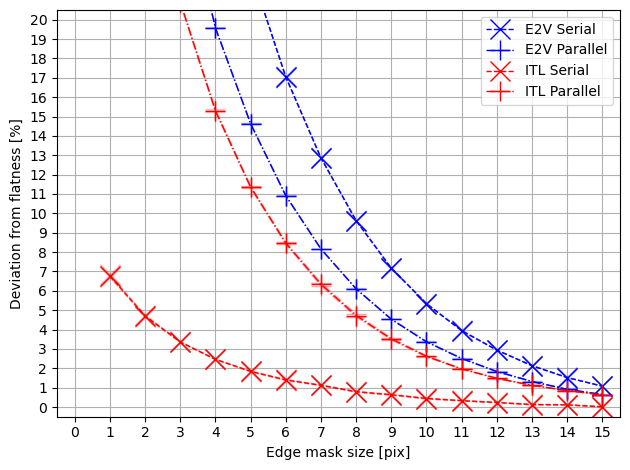

In [104]:
# make a lineplot that calls out the threshold levels

fig,ax = plt.subplots()
# label_arr = np.array([],dtype=str)
for array,fig_kwargs,label in zip([E2V_serial_arr,E2V_parallel_arr,ITL_serial_arr,ITL_parallel_arr],myKwargs,label_arr):
    for run in array:
        ax.plot(pix_buffer,run,**fig_kwargs,alpha=0.2) # plot the individual runs, with a lower alpha
    mean_arr = array.mean(axis=0)
    ax.plot(pix_buffer,mean_arr,label=label,**fig_kwargs)
    # label_arr = np.append(label_arr,lab.get_label())

# Format the figure
ax.set_xlabel("Edge mask size [pix]")
ax.set_ylabel("Deviation from flatness [%]")
ax.set_xlim(-0.5,15.5)
ax.set_xticks(np.arange(0,16,step=1))
# bottom, top = ax.get_ylim()
# bottom, top = np.floor(bottom), np.ceil(top)
ax.set_yticks(np.arange(0,21,step=1))
ax.set_ylim(-0.5,20.5)
ax.grid()
ax.legend(ncols=1,loc='upper right')
fig.tight_layout()

fig.savefig("/home/s/seanmacb/Camera/Run6Comparisons/Figures/LCADeviationThresholds/AllPixThresholds.jpg".format(run_num,pix_num),dpi=200)

# Redoing now with fixed buffer size, defined by below function

In [5]:
def serialSuggestion(manu_type):
    if manu_type=='ITL':
        return 5
    elif manu_type=="E2V":
        return 8
    else:
        print("Error encountered on manu_type")
        return

def parallelSuggestion(manu_type):
    if manu_type=='ITL':
        return 12
    elif manu_type=="E2V":
        return 10
    else:
        print("Error encountered on manu_type")
        return

Run id: 13162_w_2023_22
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 100
Finished detector 125
Finished detector 150
Finished detector 175
Finished detector 200
Run id: 13391_w_2023_24
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 100
Finished detector 125
Finished detector 150
Finished detector 175
Finished detector 200
Run id: 13401_w_2023_24
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 100
Finished detector 125
Finished detector 150
Finished detector 175
Finished detector 200
Run id: 13505_w_2023_41
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 100
Finished detector 125
Finished detector 175
Finished detector 200
Run id: 13550_w_2023_41
Finished detector 0
Finished detector 25
Finished detector 50
Finished detector 75
Finished detector 100
Finished detector 150
Fin

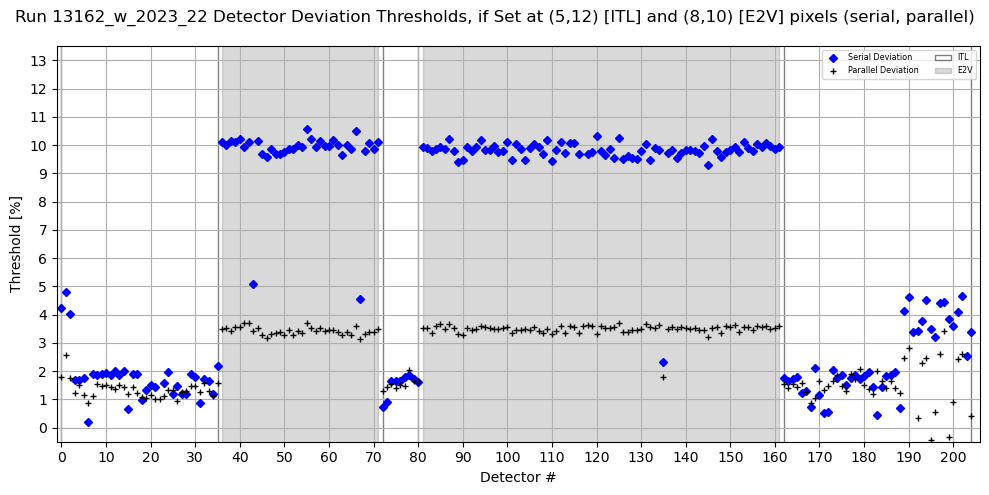

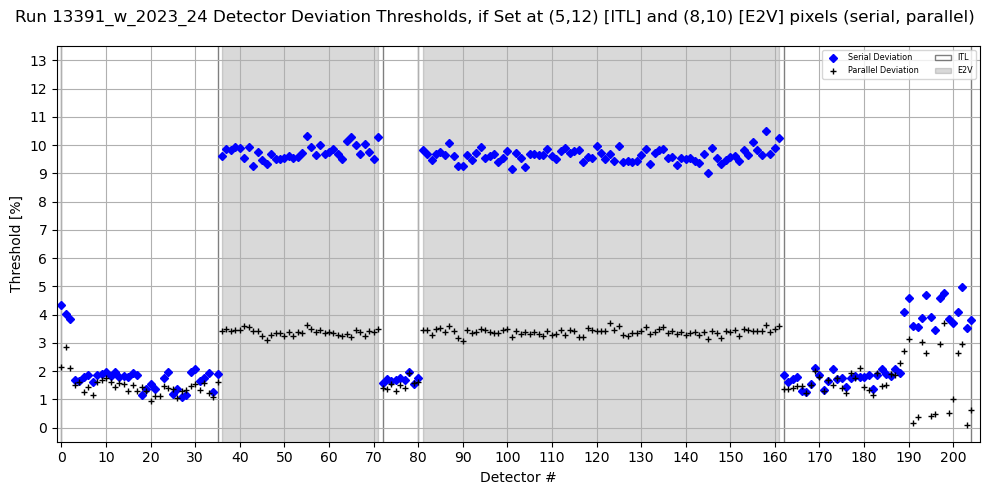

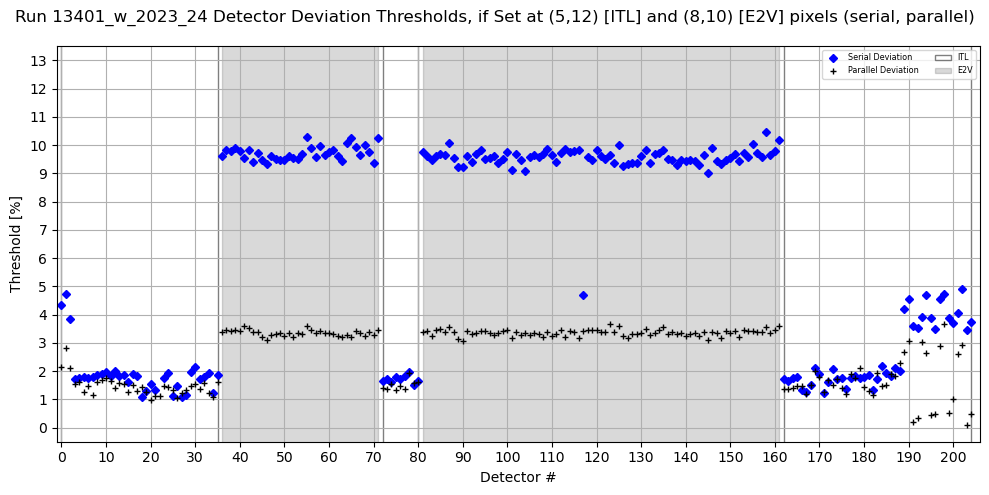

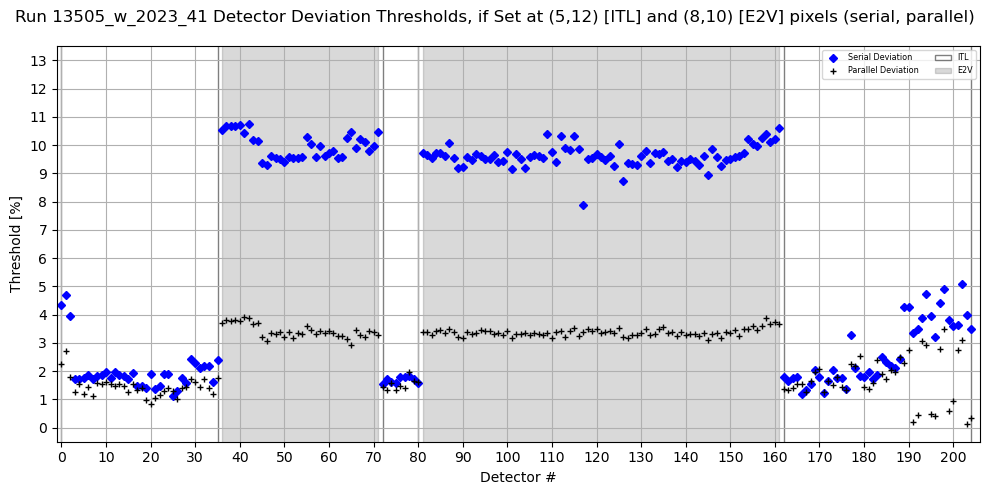

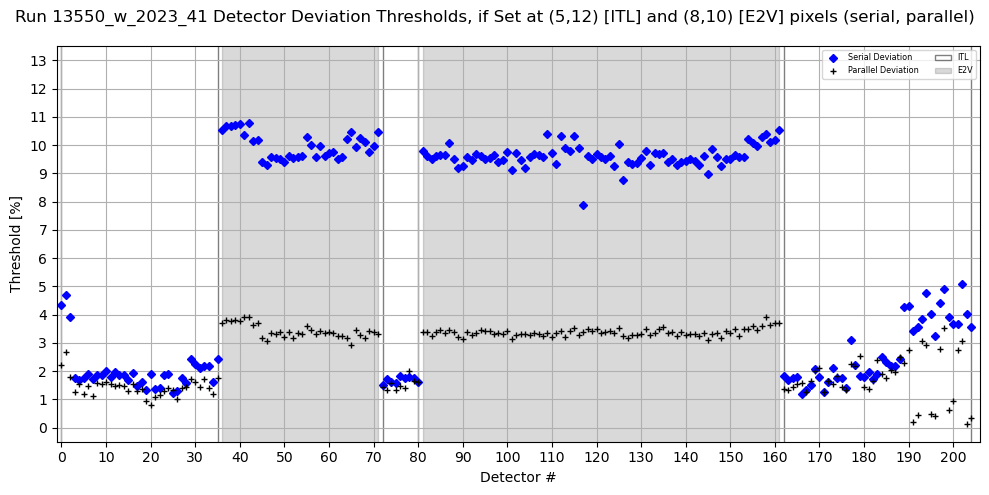

In [6]:
img= 'flat'
# run = ['13391_w_2023_24','13401_w_2023_24','13505_w_2023_41', '13550_w_2023_41'] # 13505 and 13550 are gain corrected, 
run = ['13162_w_2023_22','13391_w_2023_24','13401_w_2023_24','13505_w_2023_41', '13550_w_2023_41']
repo_arr = ["/repo/main","/repo/ir2","/repo/ir2","/repo/ir2","/repo/ir2"]
axes = ["x","y"]
norm=True
median=True

for run_num,repo in zip(run,repo_arr):
    print("Run id: {}".format(run_num))
    serial_Arr,parallel_Arr = np.array([]),np.array([])
    for detector in np.arange(0,205):
        # Measure for serial
        avg_arr,std_arr,axis,manu_type = rsu.statisticsHandler(img,run_num,detector,'x',norm,median,repo=repo)
        serial_Arr = np.append(serial_Arr, np.mean([rsu.findEdgeCutoffs(avg_arr,side='left',sugOverride=serialSuggestion(manu_type)),
                                                    rsu.findEdgeCutoffs(avg_arr,side='right',sugOverride=serialSuggestion(manu_type))]))
        # Measure for parallel
        avg_arr,std_arr,axis,manu_type = rsu.statisticsHandler(img,run_num,detector,'y',norm,median,repo=repo)
        parallel_Arr = np.append(parallel_Arr, np.mean([rsu.findEdgeCutoffs(avg_arr,side='left',sugOverride=parallelSuggestion(manu_type)),
                                                        rsu.findEdgeCutoffs(avg_arr,side='right',sugOverride=parallelSuggestion(manu_type))]))
            # midline_Arr = np.append(midline_Arr, rsu.findMinMidline(avg_arr)) # be more precise with the midline calculation - currently doing four, need to do 5
        if detector%25==0:
            print("Finished detector",detector)
    
    # Make the plot here

    ITL_bounds = [  0,  35,  72, 80, 162, 204]
    E2V_bounds = [ 36,  71, 81, 161]
    
    fig,ax = plt.subplots(figsize=[10,5])
    
    fig.suptitle(r"Run {} Detector Deviation Thresholds, if Set at (5,12) [ITL] and (8,10) [E2V] pixels (serial, parallel)".format(run_num))
    
    lab1, = ax.plot(np.arange(0,205),serial_Arr,label="Serial Deviation",color='blue',marker="D",ls='None',markersize=4)
    lab2, = ax.plot(np.arange(0,205),parallel_Arr,label="Parallel Deviation",color='black',marker="+",ls='None',markersize=4)
    # lab3, = ax.plot(np.arange(0,205)[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"],
    #         midline_Arr[rsu.get_serial_from_number(np.arange(0,205)) == "E2V"],label="Mid-line Deviation",
    #         color='green',marker=".",markersize=10,ls="None")
    
    # ax.axhline(1,label="ITL serial edge from global",ls="-.",color='indigo')
    # ax.fill_between(np.arange(0,205),0,1,label=None,where=(rsu.get_serial_from_number(np.arange(0,205)) == "ITL"),**{"color":"blue","alpha":0.5},hatch="///")
    # lab5 = ax.fill_between(np.arange(0,205),6,7,label="Serial Global",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"blue","alpha":0.5},hatch="///")
    # ax.axhline(6,label="E2V serial edge from global",ls="--",color='violet') # This is a range of 6-7
    
    # values = [3.33,4]
    # labels = [None,"Parallel Global"]
    # kwargs = [{"color":'black',"ls":"-."},{'color':"black","ls":"-."}]
    # # It would be nice to mask these hlines
    # iter = 0
    # for bounds in (ITL_bounds,E2V_bounds):
    #     newlabel=labels[iter]
    #     startIter = 0
    #     for left,right in zip(bounds[::2],bounds[1::2]):
    #         lab6tmp = ax.hlines(values[iter],left,right,**kwargs[iter],label=newlabel)
    #         # print(left,right)
    #         if startIter==0:
    #             lab6 = lab6tmp
    #             newlabel = None
    #             startIter +=1
    #     iter+=1
    
    # ax.axhline(3.33,label="ITL parallel edge from global",ls="-.",color='indigo')
    # ax.axhline(4,label="E2V parallel edge from global",ls="--",color='goldenrod')
    
    # Plot the range at which the E2V midline bloom plot was to be centered
    # lab4 = ax.fill_between(np.arange(0,205),2,3,label="Midline Global",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"green","alpha":0.3,"hatch":"///"})

    bottom, top = ax.get_ylim()
    
    # this is to show which are E2V, and which are ITL
    lab7 = ax.fill_between(np.arange(0,205),-1,200,label="ITL",where=(rsu.get_serial_from_number(np.arange(0,205)) == "ITL"),**{"color":"white","alpha":0.5,"edgecolor":"black"})
    lab8 = ax.fill_between(np.arange(0,205),-1,200,label="E2V",where=(rsu.get_serial_from_number(np.arange(0,205)) == "E2V"),**{"color":"black","alpha":0.15})
    # lab9 = ax.hlines(20,0,205,colors='red',ls='dashed',label="Defect threshold")

    
    
    ax.set_xlabel("Detector #")
    ax.set_ylabel("Threshold [%]")
    ax.set_xlim(-1,206)
    ax.set_yticks(np.arange(0,25,step=1))
    ax.set_ylim(-0.5,13.5)
    ax.set_xticks(np.arange(0,205,step=10))
    ax.grid()
    
    ax.legend(ncols=2,handles = [lab1,lab2,lab7,lab8],fontsize='xx-small',loc=1)
    
    fig.tight_layout()
    
    fig.show()
    
    fig.savefig("/home/s/seanmacb/Camera/Run6Comparisons/Figures/LCADeviationThresholds/{}_fixed9pixSum.jpg".format(run_num),dpi=200)

# There is a weird fluctuation in serial edge sizes for some detectors (ex. 22 and 117 for run 6)

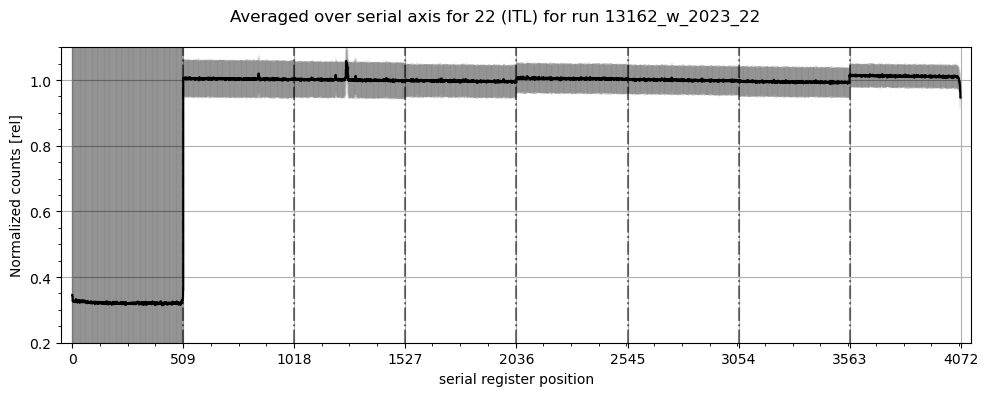

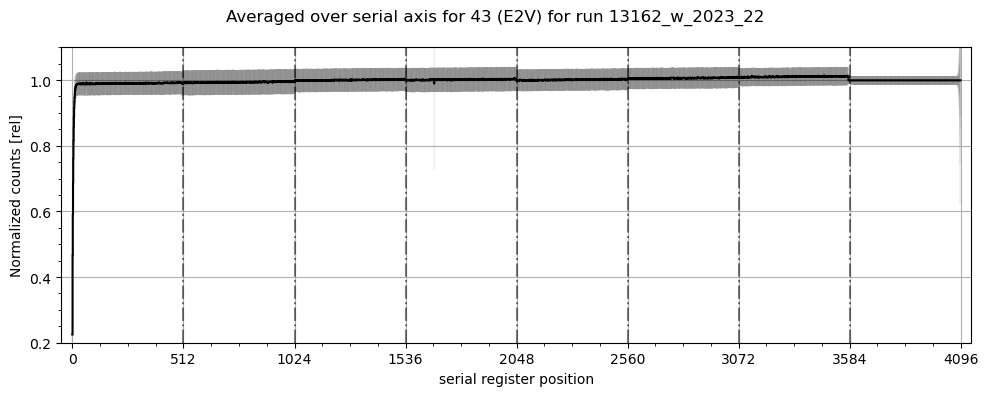

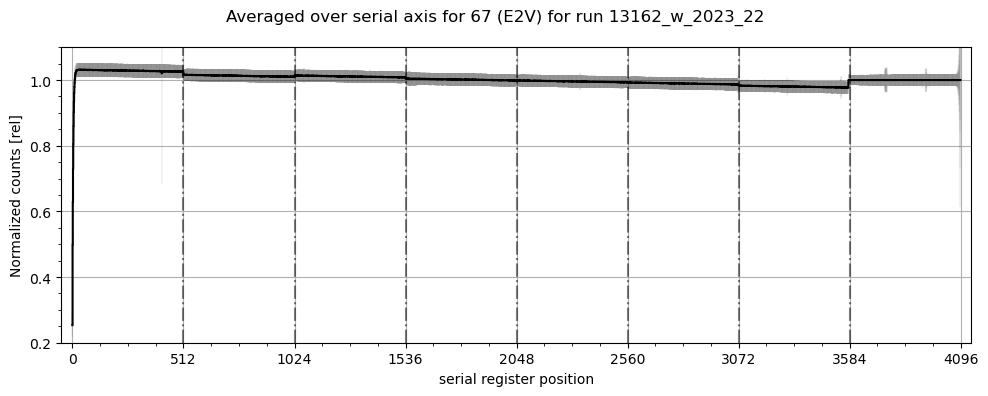

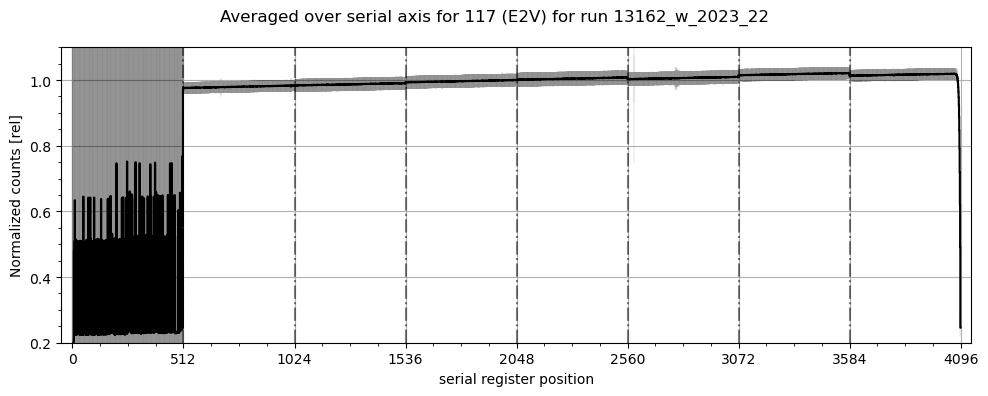

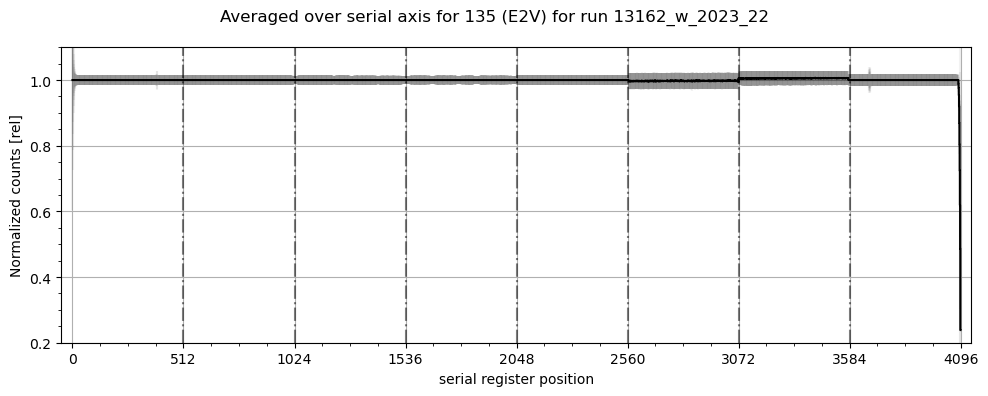

In [4]:
# lims = [[0,1.1],[0.2,1.1]]
# for det,limit in zip([117,22],lims):
for det in [22,43,67,117,135]:
    for r in ["13162_w_2023_22"]:
        fig = rsu.generate1DStatistics_oneDetector("flat",r,det,'x',norm=True,median=True,threshold=False,runlabel=r,ylim=[0.2,1.1],repo='/repo/main')
        fig.show()

### Troubling detectors and runs
- Detector 22
    - 13162
    - 13391
    - 13401
- Detector 43
    - 13162
- Detector 67
    - 13162
- Detector 117
    - 13162
    - 13401
    - 13505
    - 13550
- Detector 135
    - 13162

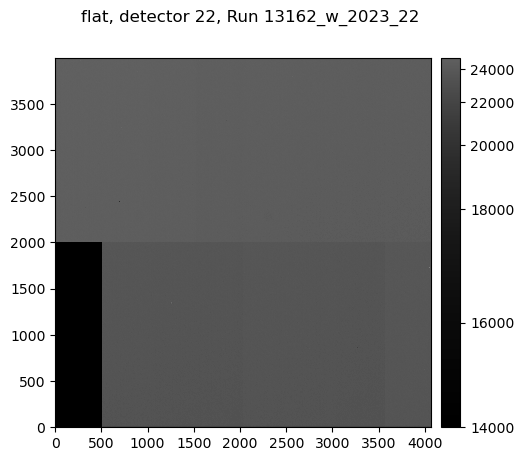

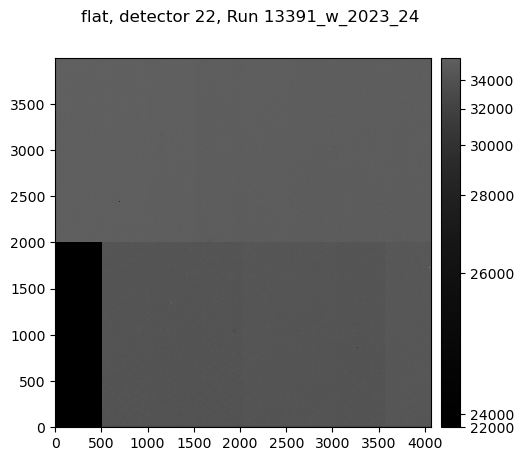

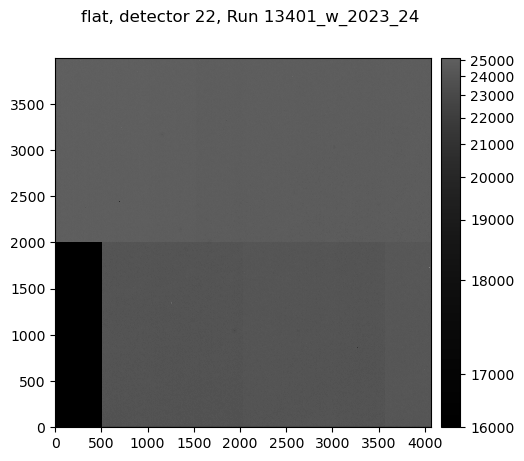

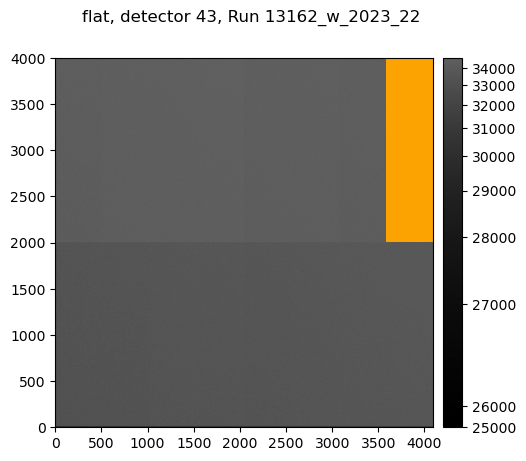

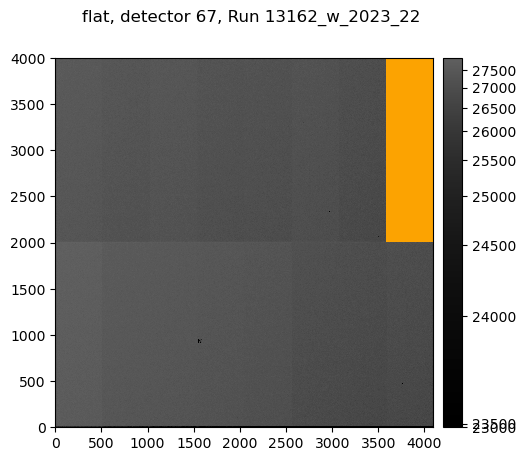

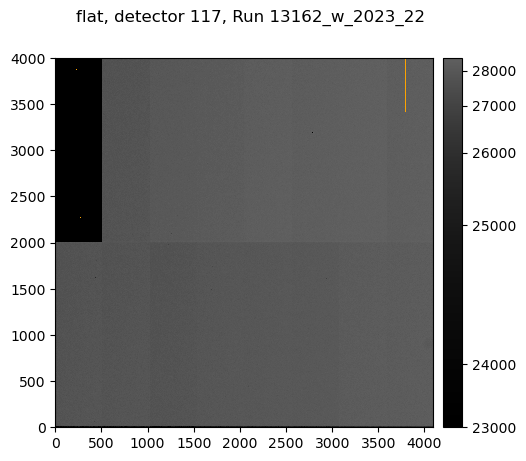

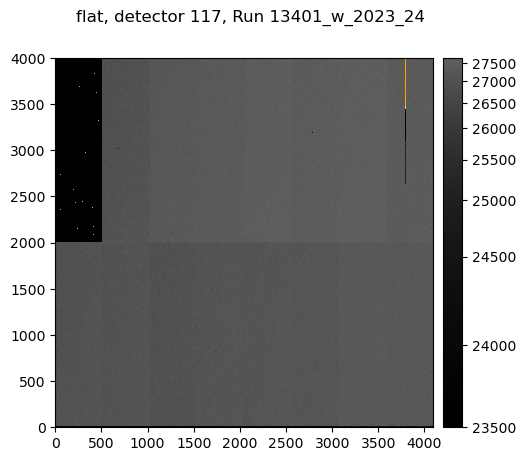

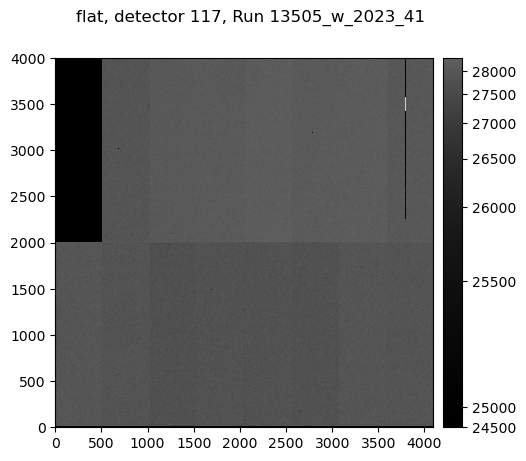

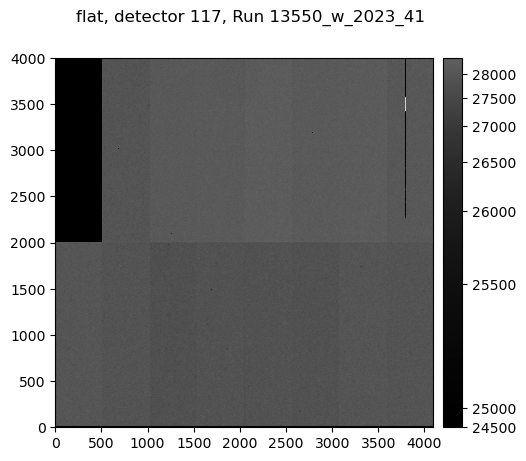

<Figure size 640x480 with 0 Axes>

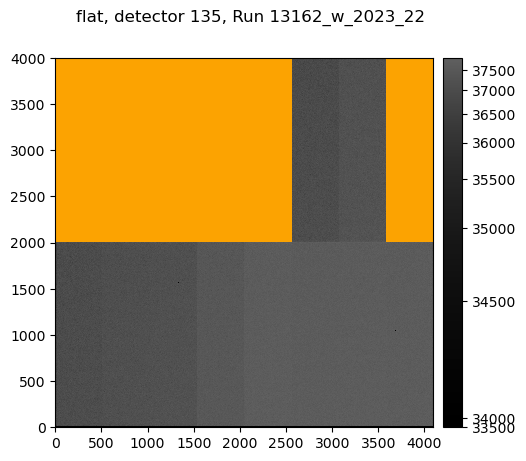

In [4]:
detector_run = [(22,["13162_w_2023_22",'13391_w_2023_24','13401_w_2023_24']),
                (43,["13162_w_2023_22"]),
                (67,["13162_w_2023_22"]),
                (117,["13162_w_2023_22",'13401_w_2023_24','13505_w_2023_41', '13550_w_2023_41']),
                (135,["13162_w_2023_22"])]

for detr in detector_run:
    det,runs = detr
    for r in runs:
        if r.__contains__("13162"):
            rep = "/repo/main"
        else:
            rep = '/repo/ir2'
        rsu.makeSimpleImg("flat",r,det,repo=rep)

In [17]:
butler = rsu.daf_butler.Butler("/repo/main",collections='LSSTCam/raw/all')

In [18]:
refs = butler.registry.queryDatasets("raw", where="exposure.science_program in ('12606', '12741', '12845')")